In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [330]:
from glob import glob
import os

data_dir = "../archive/chest_xray"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

len(glob(f"{train_dir}/*/*.jpeg")), len(glob(f"{test_dir}/*/*.jpeg"))

(5216, 640)

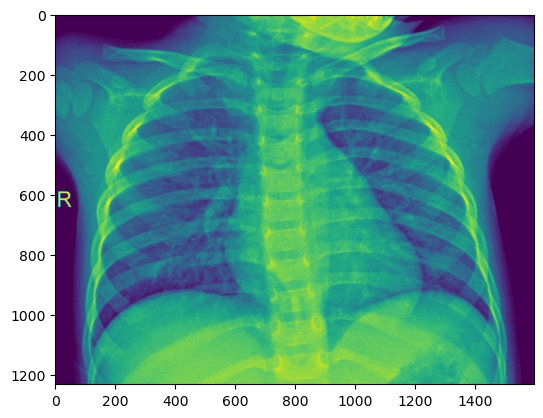

In [331]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread(glob(f"{train_dir}/*/*")[0]))

In [332]:
train_label = []
test_label = []

for i in range(len(glob(f"{train_dir}/*/*.jpeg"))):
    
    temp_label = glob(f"{train_dir}/*/*.jpeg")[i].split('/')[-2]
    if temp_label == 'PNEUMONIA':
        train_label.append(1)
    else:
        train_label.append(0)
        
for i in range(len(glob(f"{test_dir}/*/*.jpeg"))):
    
    temp_label = glob(f"{test_dir}/*/*.jpeg")[i].split('/')[-2]
    if temp_label == 'PNEUMONIA':
        test_label.append(1)
    else:
        test_label.append(0)

In [333]:
from PIL import Image
import torch
import cv2

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, path, y, transform):
        self.path = path
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = cv2.imread(self.path[index])
        x = Image.fromarray(x)
        x = self.transform(x)
        y = self.y[index]
        
        return x, y

In [334]:
print(len(train_label))

5216


In [335]:
from sklearn.model_selection import train_test_split

train_image, val_image, train_label, val_label = train_test_split(glob(f"{train_dir}/*/*.jpeg"), train_label, test_size=0.15, stratify=train_label)

In [336]:
print(len(train_image), len(val_image), len(glob(f"{test_dir}/*/*.jpeg")))

4433 783 640


In [337]:
from torchvision import transforms
# 쿠다 때문에 사이즈가 (64, 64) 밖에 안되는데 이게 맞나?
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [338]:
train_ds = custom_dataset(train_image, train_label, train_transform)
val_ds = custom_dataset(val_image, val_label, train_transform)
test_ds = custom_dataset(glob(f"{test_dir}/*/*.jpeg"), test_label, train_transform)

In [339]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=8)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=8)

In [340]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])


In [341]:
import torch.nn as nn

class Find_PNEUMONIA(nn.Module):
    def __init__(self):
        super(Find_PNEUMONIA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(8 * 8 * 128, 1)
        self.sigmoid = nn.Sigmoid()
        # self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 128)
        x = self.linear(x)
        x = self.sigmoid(x)
        
        return x

In [342]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [343]:
model = Find_PNEUMONIA().to(device)
print(model)

Find_PNEUMONIA(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=8192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [344]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [345]:
from sklearn.metrics import accuracy_score
import tqdm
import numpy as np

def train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()
        
        for data, target in tqdm.tqdm(train_dataloader):
            
            data = data.to(device)
            target = target.to(device).float()
            
            y_pred = model(data)
            y_pred = torch.squeeze(y_pred)

            loss = criterion(y_pred, target)

            y_pred_binary = (y_pred >= 0.5).long()
            acc = accuracy_score(target.cpu(), y_pred_binary.cpu())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_acc += acc
            
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)
        
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        print(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train ACC: {avg_train_acc:.4f}')
        
        model.eval()
        epoch_validation_loss = 0.0
        epoch_validation_acc = 0.0
        with torch.no_grad():
            for data, target in tqdm.tqdm(val_dataloader):
                
                data = data.to(device)
                target = target.to(device).float()

                y_pred = model(data)
                y_pred = torch.squeeze(y_pred)
                
                loss = criterion(y_pred, target)
                
                epoch_validation_loss += loss.item()

                y_pred_binary = (y_pred >= 0.5).long()
                acc = accuracy_score(target.cpu(), y_pred_binary.cpu())
                
                epoch_validation_acc += acc

        avg_validation_acc = epoch_validation_acc / len(val_dataloader)
        avg_validation_loss = epoch_validation_loss / len(val_dataloader)

        val_losses.append(avg_validation_loss)
        val_accs.append(avg_validation_acc)

        print(f'Validation Loss: {avg_validation_loss:.4f}, Validation ACC: {avg_validation_acc:.4f} \n')

    return train_losses, train_accs, val_losses, val_accs

In [346]:
epochs=5

In [347]:
train_losses, train_accs, val_losses, val_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

100%|██████████| 554/554 [00:53<00:00, 10.36it/s]


Epoch: 1, Train Loss: 0.2428, Train ACC: 0.8982


100%|██████████| 98/98 [00:08<00:00, 11.25it/s]


Validation Loss: 0.1127, Validation ACC: 0.9554 



100%|██████████| 554/554 [00:51<00:00, 10.66it/s]


Epoch: 2, Train Loss: 0.1198, Train ACC: 0.9513


100%|██████████| 98/98 [00:08<00:00, 11.57it/s]


Validation Loss: 0.1187, Validation ACC: 0.9579 



100%|██████████| 554/554 [00:52<00:00, 10.53it/s]


Epoch: 3, Train Loss: 0.1035, Train ACC: 0.9616


100%|██████████| 98/98 [00:08<00:00, 11.51it/s]


Validation Loss: 0.0964, Validation ACC: 0.9617 



100%|██████████| 554/554 [00:52<00:00, 10.47it/s]


Epoch: 4, Train Loss: 0.0936, Train ACC: 0.9637


100%|██████████| 98/98 [00:08<00:00, 11.52it/s]


Validation Loss: 0.0825, Validation ACC: 0.9681 



100%|██████████| 554/554 [00:53<00:00, 10.29it/s]


Epoch: 5, Train Loss: 0.0788, Train ACC: 0.9691


100%|██████████| 98/98 [00:08<00:00, 11.27it/s]

Validation Loss: 0.0920, Validation ACC: 0.9656 



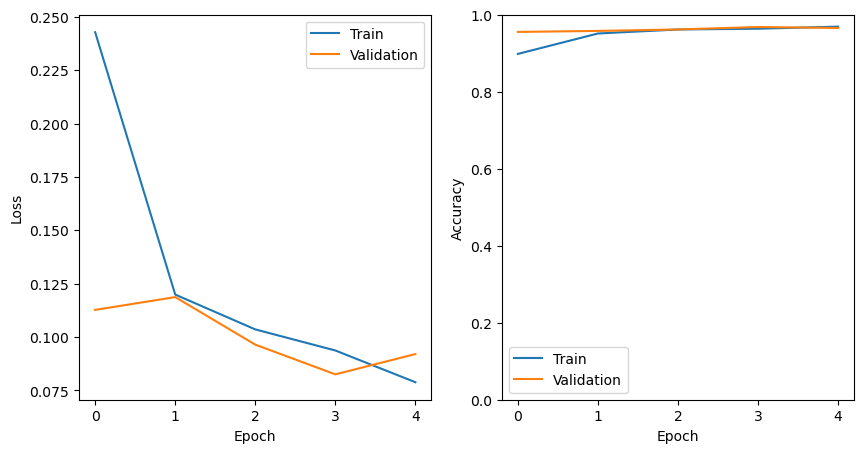

In [348]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [349]:
torch.save(model.state_dict(), "model.pth")

In [350]:
model.load_state_dict(torch.load("model.pth"))

/tmp/ipykernel_31034/1722216506.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [351]:
print(len(test_dataloader), len(train_dataloader), len(val_dataloader))

80 554 98


In [352]:
def predict(model, dataloader):
    model.eval()
    all_preds = []
    print(len(dataloader))
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            
            outputs = model(data)
            outputs = torch.squeeze(outputs)
            preds = (outputs >= 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            
    return all_preds

In [353]:
preds = predict(model, test_dataloader)

80


In [355]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(test_label, preds)

array([[113, 129],
       [  7, 391]])

In [356]:
classification_report(test_label, preds)

'              precision    recall  f1-score   support\n\n           0       0.94      0.47      0.62       242\n           1       0.75      0.98      0.85       398\n\n    accuracy                           0.79       640\n   macro avg       0.85      0.72      0.74       640\nweighted avg       0.82      0.79      0.77       640\n'

In [357]:
accuracy_score(test_label, preds)

0.7875

In [359]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(test_label, preds, average="macro"))
print(precision_score(test_label, preds, average="macro"))
print(recall_score(test_label, preds, average="macro"))

0.7380806220585225
0.8467948717948718
0.724677104530919
